# Overview

In [14]:
import pandas as pd
import numpy as np


import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('whitegrid')

from collections import defaultdict
from progressbar import ProgressBar
import re
from multiprocessing import Pool
import time

import scipy
import networkx as nx
import re

import os
import itertools

from pathlib import Path

from collections import Counter
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [15]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ShuffleSplit

In [16]:
basedir = '/Users/italodovalle/local/polyphenols/'
infolder = basedir + 'data/'
outfolder = basedir + 'output/'
dbs = basedir + 'data/databases/'

In [17]:
#os.chdir(basedir + '/python')

import toolbox.network_utils as network_utils
import toolbox.databases_utils as databases_utils


GenRev not found, steiner wont work
Import error: Negex. Using keyword matching instead
Import error: Funcassociate. Make sure that funcassociate is in toolbox!


In [18]:
import warnings
warnings.filterwarnings("ignore")

# AUC + Bootstrap + Precision All chemicals

In [26]:
#infile = outfolder + 'tables/proximity_chemicals_diseases_zscore_edited.csv'

#infile = outfolder + 'HI_2019/proximity_zscores.csv'
infile = outfolder + 'randomization_study/gallic_acid_emp_p.csv'
ctd = pd.read_csv(infolder + 'ctd_polyphenols_implicit_explicit_3.csv',index_col = 0)


measures = ['dc', 'z_score','emp_p']

# negative measures
### measures that lowers values represent more significance
measures = ['z_score', 'dc', 'emp_p']
negative_measures = ['z_score', 'dc', 'emp_p']
selected_chemicals = ['gallic acid']
selected_diseases = None

target_columns = ['chemical','disease']

explicit = 'DirectEvidence'
implicit = 'therapeutic'

In [20]:
dt = pd.read_csv(infile,index_col = 0, comment='#')
print (dt.shape)
dt['chemical'] = [i.lower() for i in dt.chemical]
selected_chemicals = None

dx = pd.merge(dt[target_columns + measures], ctd, 
              on =target_columns, 
              how='outer')

if 'n_mapped_chemical' in dx.columns:
    if selected_diseases:
        dx = dx[(dx.disease.isin(selected_diseases)) & (~dx.n_mapped_chemical.isnull())]
    if selected_chemicals:
        dx = dx[(dx.chemical.isin(selected_chemicals)) & (~dx.n_mapped_chemical.isnull())]
else:
    if selected_diseases:
        dx = dx[(dx.disease.isin(selected_diseases))]
    if selected_chemicals:
        dx = dx[(dx.chemical.isin(selected_chemicals))]

dx = dx[~dx[measures[0]].isnull()]
print (dx.shape)
dx.head()

(299, 7)
(299, 7)


,chemical,disease,dc,z_score,emp_p,DirectEvidence,therapeutic
0,gallic acid,kidney diseases,2.303571,-0.840935,0.024,NaN,1.0
1,gallic acid,chromosome disorders,2.264706,-0.959991,0.042,NaN,NaN
2,gallic acid,"diabetes mellitus, type 1",2.287234,-0.897667,0.012,NaN,NaN
3,gallic acid,cardiomegaly,2.216216,-0.675284,0.053,NaN,NaN
4,gallic acid,anemia,2.150000,-0.839244,0.009,NaN,NaN


In [21]:
dx['therapeutic'] = dx['therapeutic'].fillna(0)
dx['buf'] = dx.DirectEvidence
dx.loc[~dx.DirectEvidence.isnull(),'DirectEvidence'] = 1
dx.loc[dx.DirectEvidence.isnull(),'DirectEvidence'] = 0
del dx['buf']


print ('Explicit')
print (dx[dx[explicit] == 1].shape[0], 'known')
print (dx[dx[explicit] == 0].shape[0], 'unknown')
print ('Implicit + Explicit')
print (dx[dx.therapeutic == 1].shape[0], 'known')
print (dx[dx.therapeutic == 0].shape[0], 'unknown')

Explicit
5 known
294 unknown
Implicit + Explicit
42 known
257 unknown


In [22]:
#outfile = outfolder + 'OtherInteractomes/hiunion_zscore_proximity_labels.csv'
#dx.to_csv(outfile)

In [32]:
def calculcate_performance(chemical, measures=measures, label = 'therapeutic'):
    dw = dx[dx.chemical == chemical]
    
    res = defaultdict(dict)
    x = 0 ## counter
    for col in measures:
        sub = dw[[label, col]]
        fpr, tpr, thresholds = metrics.roc_curve(1 - sub[label], sub[col])
        roc_auc = metrics.auc(fpr, tpr)
        ### bootstrap
        sub = sub.reset_index()
        rng = np.random.RandomState(42)
        bootstraps = []
        for j in range(2000):
            # bootstrap by sampling with replacement on the prediction indices
            indices = rng.random_integers(0, len(sub.index) - 1, 150)
            boot = sub.loc[indices]
            while boot[boot[label] == 1].shape[0] == 0:
                indices = rng.random_integers(0, len(sub.index) - 1, 150)
                boot = sub.loc[indices]
            fpr, tpr, thresholds = metrics.roc_curve(1 - boot[label], boot[col])
            roc_auc_b = metrics.auc(fpr, tpr)
            bootstraps.append(roc_auc_b)
        bootstraps.sort()
        s_lower = np.percentile(bootstraps, 2.5)
        s_upper = np.percentile(bootstraps, 97.5)
        res[x]['value'] = roc_auc
        res[x]['measure'] = col
        res[x]['ci_upper'] = s_upper
        res[x]['ci_lower'] = s_lower
        res[x]['error_l'] = roc_auc - s_lower
        res[x]['error_u'] = s_upper - roc_auc
        
        
        ### precision
        
        for ntop in [10, 25, 50]:
            sub = dw[[label, col]]
            sub = sub.sort_values(by = col)
            top = sub.iloc[:ntop]
            tp = top[top[label] == 1].shape[0]
            fp = top[top[label] == 0].shape[0]
            pre = 1.*tp/(tp + fp)
            res[x]['prec_top%d'%ntop] = pre
         
        
        """
        ## precision - top absolute proximity that z < -0.5
        if not 'z' in col:
            for ntop in [10, 25, 50]:
                sub = dw[[label, col, 'z_%s'%col]]
                sub = sub[sub['z_%s'%col] < -0.5]
                pre = 0
                if not sub.shape[0] == 0:
                    sub = sub.sort_values(by = col)
                    top = sub.iloc[:ntop]
                    tp = top[top[label] == 1].shape[0]
                    fp = top[top[label] == 0].shape[0]
                    pre = 1.*tp/(tp + fp)
                res[x]['prec_relative_top%d'%ntop] = pre
        """    
        x = x+1


    table = pd.DataFrame.from_dict(res,orient='index')
    table['chemical'] = chemical
    return (table)

In [33]:
p = Pool(8)
samples = list(set(dx.chemical))
res = p.map(calculcate_performance, samples)
p.close()
df = pd.concat(res)

In [34]:
df = pd.concat(res)


In [35]:
df

,value,measure,ci_upper,ci_lower,error_l,error_u,prec_top10,prec_top25,prec_top50,chemical
0,0.510283,z_score,0.634407,0.383452,0.126832,0.124124,0.0,0.04,0.08,gallic acid
1,0.596813,dc,0.724169,0.461912,0.134901,0.127356,0.2,0.24,0.26,gallic acid
2,0.511256,emp_p,0.642402,0.380661,0.130595,0.131146,0.1,0.08,0.08,gallic acid


In [16]:
#outfile = outfolder + 'OtherInteractomes/hiunion_zscore_proximity_performance.csv'
#df.to_csv(outfile)

In [15]:
df[df.chemical == '(-)-epigallocatechin 3-o-gallate']

,value,measure,ci_upper,ci_lower,error_l,error_u,prec_top10,prec_top25,prec_top50,prec_relative_top10,prec_relative_top25,prec_relative_top50,chemical
0,0.700489,closest,0.795334,0.599499,0.100990,0.094845,0.7,0.64,0.58,0.7,0.56,0.40,(-)-epigallocatechin 3-o-gallate
1,0.502136,z_closest,0.608831,0.394661,0.107475,0.106695,0.3,0.28,0.32,NaN,NaN,NaN,(-)-epigallocatechin 3-o-gallate
2,0.529842,shortest,0.624832,0.425371,0.104471,0.094990,0.4,0.24,0.24,0.4,0.24,0.26,(-)-epigallocatechin 3-o-gallate
3,0.524334,z_shortest,0.623688,0.421749,0.102585,0.099354,0.3,0.32,0.24,NaN,NaN,NaN,(-)-epigallocatechin 3-o-gallate


In [57]:
dx[dx.disease.str.contains('diabetes')]

,chemical,disease,closest,shortest,z_closest,z_shortest,DirectEvidence,therapeutic
39,(-)-epigallocatechin 3-o-gallate,"diabetes mellitus, type 2",1.666667,2.487834,-1.294003,-2.290555,1,1.0
184,(-)-epigallocatechin 3-o-gallate,diabetes mellitus,1.568627,2.496837,-1.088747,-2.442723,0,1.0
224,(-)-epigallocatechin 3-o-gallate,"diabetes mellitus, type 1",1.647059,2.520025,-1.141251,-2.505548,0,0.0


In [14]:
df[['chemical', 'measure', 'value', 'ci_upper', 'ci_lower','prec_top10', 'prec_top25','prec_relative_top10','prec_relative_top25']]

,chemical,measure,value,ci_upper,ci_lower,prec_top10,prec_top25,prec_relative_top10,prec_relative_top25
0,resveratrol,closest,0.685379,0.770004,0.595527,1.0,1.00,1.0,1.00
1,resveratrol,z_closest,0.535556,0.633899,0.439651,1.0,0.80,NaN,NaN
2,resveratrol,shortest,0.646465,0.740393,0.539414,0.7,0.64,0.6,0.60
3,resveratrol,z_shortest,0.699596,0.786650,0.610806,1.0,0.92,NaN,NaN
0,butein,closest,0.766329,0.946309,0.533557,0.0,0.04,0.0,0.00
...,...,...,...,...,...,...,...,...,...
3,galloyl glucose,z_shortest,0.779279,0.959732,0.510067,0.0,0.04,NaN,NaN
0,(-)-epigallocatechin 3-o-gallate,closest,0.700489,0.795334,0.599499,0.7,0.64,0.7,0.56
1,(-)-epigallocatechin 3-o-gallate,z_closest,0.502136,0.608831,0.394661,0.3,0.28,NaN,NaN
2,(-)-epigallocatechin 3-o-gallate,shortest,0.529842,0.624832,0.425371,0.4,0.24,0.4,0.24


In [58]:
dq1 = dx[(dx.chemical == '(-)-epigallocatechin 3-o-gallate')]

In [59]:
comp = pd.read_csv(outfolder + 'tables/proximity_chemicals_diseases_zscore_therapeutic_edited.csv')
dq2 = comp[(comp.chemical == '(-)-epigallocatechin 3-o-gallate')]

In [60]:
dq = pd.merge(dq1, dq2, on = 'disease', suffixes=('_new', '_old'))
#dq = dq[['disease', 'z_closest_new', 'z_closest_old', 'therapeutic_old']]

(-5, 2.5)

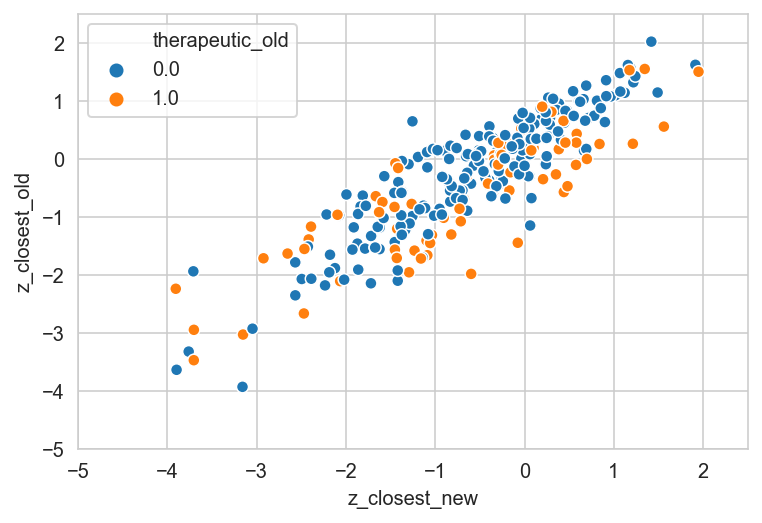

In [61]:
fig, ax = plt.subplots(1,1)
sns.scatterplot(x = 'z_closest_new', y = 'z_closest_old',hue='therapeutic_old',data=dq,ax=ax)
ax.set_xlim(-5, 2.5)
ax.set_ylim(-5, 2.5)

In [14]:
outfile = outfolder + 'Tests/randomized_targets_set_only_proximity_performance.csv'
df.to_csv(outfile)

In [14]:
cl = df[df.measure == 'closest']

In [15]:
cl[cl.value > 0.7].shape

(33, 13)

In [48]:
df = pd.read_csv(outfolder + 'PDB_Interactions/pdb_interactions_performance.csv', index_col = 0)
df.head()

,ci_upper,prec_top50,value,prec_relative_top50,prec_relative_top25,error_l,ci_lower,error_u,prec_relative_top10,prec_top25,measure,prec_top10,chemical
0,0.966443,0.06,0.810997,0.06,0.08,0.094792,0.716205,0.155446,0.2,0.08,closest,0.2,coumestrol
1,0.913846,0.04,0.707474,NaN,NaN,0.248092,0.459382,0.206372,NaN,0.04,z_closest,0.1,coumestrol
2,0.840765,0.02,0.699098,0.02,0.00,0.239883,0.459215,0.141667,0.0,0.00,shortest,0.0,coumestrol
3,0.961381,0.14,0.900344,NaN,NaN,0.095568,0.804776,0.061037,NaN,0.12,z_shortest,0.0,coumestrol
0,0.792766,0.46,0.706573,0.38,0.60,0.095902,0.610671,0.086193,0.8,0.48,closest,0.6,genistein


In [47]:
comp = pd.read_csv(outfolder + 'tables/proximity_chemicals_diseases_performance_edited.csv', index_col = 0)
comp = comp[comp.chemical.isin(df.chemical)]
comp.head()

,error_u,measure,prec_top25,prec_top50,prec_relative_top50,error_l,prec_relative_top10,prec_relative_top25,prec_top10,ci_lower,value,ci_upper,chemical
0,0.077050,closest,0.76,0.62,0.560000,0.085528,1.0,0.72,0.8,0.699787,0.785315,0.862365,(-)-epigallocatechin 3-o-gallate
1,0.100944,z_closest,0.32,0.40,NaN,0.103052,NaN,NaN,0.5,0.476075,0.579127,0.680071,(-)-epigallocatechin 3-o-gallate
2,0.095445,shortest,0.36,0.28,0.280000,0.101072,0.2,0.36,0.2,0.445902,0.546974,0.642419,(-)-epigallocatechin 3-o-gallate
3,0.093299,z_shortest,0.40,0.26,NaN,0.100372,NaN,NaN,0.5,0.505347,0.605719,0.699019,(-)-epigallocatechin 3-o-gallate
0,0.010922,closest,0.20,0.10,0.147059,0.032703,0.3,0.20,0.4,0.956376,0.989078,1.000000,phloridzin


In [48]:
comp[comp.chemical == '(-)-epigallocatechin 3-o-gallate']

,error_u,measure,prec_top25,prec_top50,prec_relative_top50,error_l,prec_relative_top10,prec_relative_top25,prec_top10,ci_lower,value,ci_upper,chemical
0,0.077050,closest,0.76,0.62,0.56,0.085528,1.0,0.72,0.8,0.699787,0.785315,0.862365,(-)-epigallocatechin 3-o-gallate
1,0.100944,z_closest,0.32,0.40,NaN,0.103052,NaN,NaN,0.5,0.476075,0.579127,0.680071,(-)-epigallocatechin 3-o-gallate
2,0.095445,shortest,0.36,0.28,0.28,0.101072,0.2,0.36,0.2,0.445902,0.546974,0.642419,(-)-epigallocatechin 3-o-gallate
3,0.093299,z_shortest,0.40,0.26,NaN,0.100372,NaN,NaN,0.5,0.505347,0.605719,0.699019,(-)-epigallocatechin 3-o-gallate


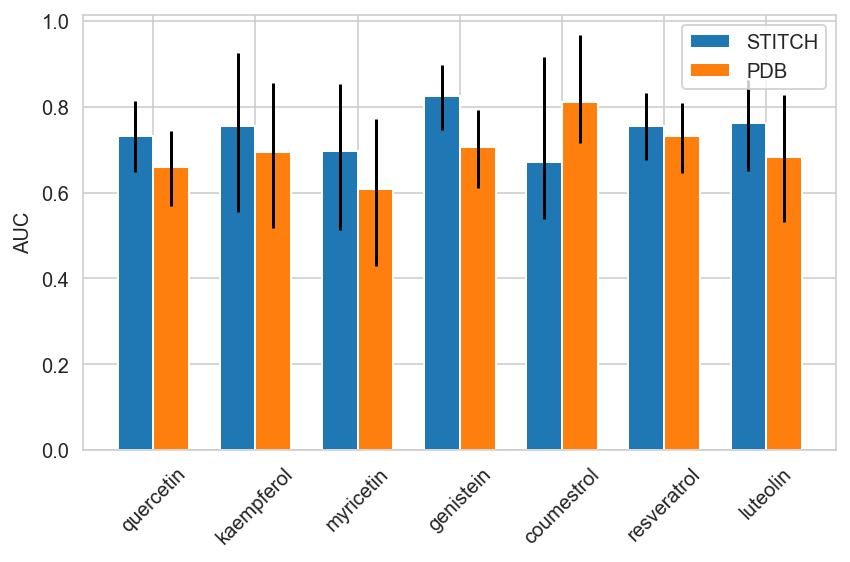

In [126]:
#def get_barplot_error(table):



"""
========
Barchart
========

A bar plot with errorbars and height labels on individual bars
"""

fig, ax = plt.subplots()
N = len(set(dm['chemical']))


colors = sns.color_palette()[:N]

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

##groups
ngroups = 2

buf = 0
rects = []

avgs = dm['value_x']
error_upper = dm.error_u_x
error_lower = dm.error_l_x
error = [error_lower,error_upper]
rect = ax.bar(ind + buf, avgs, width, color=colors[0], yerr=error,label = 'STITCH')
buf = buf + width


avgs = dm['value_y']
error_upper = dm.error_u_y
error_lower = dm.error_l_y
error = [error_lower,error_upper]
rect = ax.bar(ind + buf, avgs, width, color=colors[1], yerr=error,label = 'PDB')


# add some text for labels, title and axes ticks
ax.set_ylabel('AUC');
ax.set_xticks(ind + width / 2);
ax.set_xticklabels(dm.chemical);
ax.legend(loc='best')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45);
#ax.legend((rects1[0], rects2[0]), ('Men', 'Women'))

fig.tight_layout()
fig.savefig('../output/PDB_Interactions/comparison_auc.png', dpi = 300)

Text(0.5, 1.0, 'Measure: Closest')

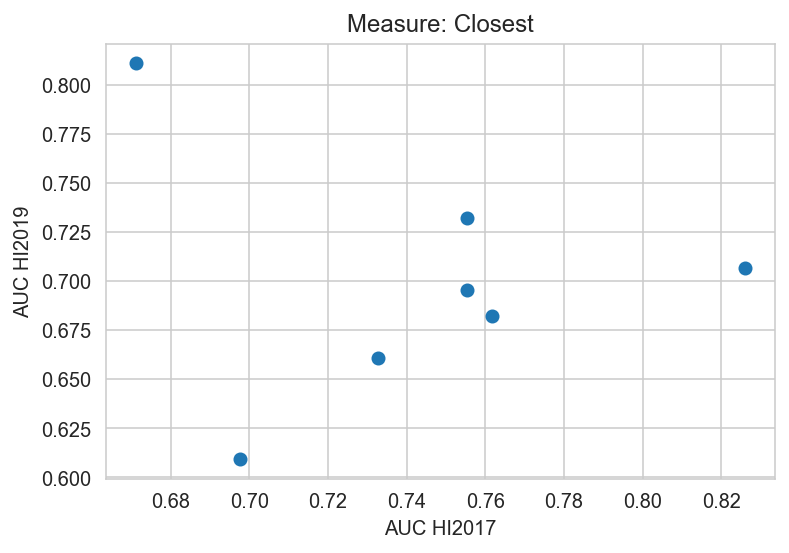

In [76]:
measure = 'closest'
dx = comp[comp.measure == measure][['chemical', 'value','error_l','error_u']]
dy = df[df.measure == measure][['chemical', 'value','error_l','error_u']]
dm = pd.merge(dx, dy, on= 'chemical')
fig, ax = plt.subplots(1,1)
ax.plot(dm.value_x, dm.value_y, 'o')
ax.set_ylabel('AUC HI2019')
ax.set_xlabel('AUC HI2017')
ax.set_title('Measure: Closest')
#fig.savefig(outfolder + 'HI_2019/auc_closest_comparison.png', dpi = 300)

In [43]:
df[df.chemical == 'luteolin']

,value,measure,ci_upper,ci_lower,error_l,error_u,prec_top10,prec_top25,prec_top50,prec_relative_top10,prec_relative_top25,prec_relative_top50,chemical
0,0.796654,closest,0.880643,0.700343,0.096312,0.083989,0.3,0.32,0.22,0.5,0.24,0.12,luteolin
1,0.477571,z_closest,0.650117,0.295324,0.182247,0.172546,0.0,0.08,0.10,NaN,NaN,NaN,luteolin
2,0.513507,shortest,0.659263,0.366654,0.146853,0.145757,0.0,0.08,0.08,0.0,0.08,0.08,luteolin
3,0.537299,z_shortest,0.665367,0.405923,0.131376,0.128069,0.0,0.00,0.06,NaN,NaN,NaN,luteolin


In [44]:
comp[comp.chemical == 'luteolin']

,error_u,measure,prec_top25,prec_top50,prec_relative_top50,error_l,prec_relative_top10,prec_relative_top25,prec_top10,ci_lower,value,ci_upper,chemical
0,0.101107,closest,0.16,0.26,0.16,0.111936,0.2,0.24,0.3,0.649818,0.761754,0.862860,luteolin
1,0.168103,z_closest,0.08,0.08,NaN,0.151790,NaN,NaN,0.1,0.315748,0.467537,0.635640,luteolin
2,0.132296,shortest,0.00,0.00,0.00,0.123904,0.0,0.00,0.0,0.299355,0.423259,0.555554,luteolin
3,0.152955,z_shortest,0.08,0.06,NaN,0.149203,NaN,NaN,0.0,0.272315,0.421517,0.574472,luteolin


In [47]:
intersection = list(set(dx[dx.value > 0.6]['chemical']) & set(dy[dy.value > 0.6]['chemical']))
old = list(dx[dx.value > 0.6]['chemical'])
new = list(dy[dy.value > 0.6]['chemical'])
[i for i in new if not i in old]

['xanthotoxin', 'isorhamnetin', 'punicalagin', 'quercetin 3-o-glucoside']

# Proximal/Distant

In [27]:
table = defaultdict(dict)
c = 0
dfs = []
for chemical in set(dx.chemical):
    dw = dx[dx.chemical == chemical]
    proximal = dw[(dw.closest <= np.percentile(dw.closest, 25)) & (dw.z_closest < -0.5)]
    tp = proximal[proximal.therapeutic == 1].shape[0]
    fp = proximal[proximal.therapeutic == 0].shape[0]
    fn = dw[dw.therapeutic == 1].shape[0] - tp
    prec = 1. * tp/(tp + fp)
    recall = 1. * tp/(tp + fn)
    table[c]['chemical'] = chemical
    table[c]['precision'] = prec
    table[c]['recall'] = recall
    
    tp = proximal[proximal.DirectEvidence == 1].shape[0]
    fp = proximal[proximal.DirectEvidence == 0].shape[0]
    fn = dw[dw.therapeutic == 1].shape[0] - tp
    prec = 1. * tp/(tp + fp)
    recall = 1. * tp/(tp + fn)
    table[c]['precision_de'] = prec
    table[c]['recall_de'] = recall
    
    dfs.append(proximal)
    c = c + 1
    
    
table = pd.DataFrame.from_dict(table, orient='index')
table.head()

,precision_de,recall_de,precision,recall,chemical
0,0.017544,0.028571,0.298246,0.485714,ellagic acid
1,0.232558,0.050000,0.813953,0.175000,trans-resveratrol
2,0.000000,0.000000,0.081633,0.470588,galangin
3,0.000000,0.000000,0.000000,0.000000,butein
4,0.000000,0.000000,0.046154,0.230769,daidzin


In [19]:
table.to_csv(outfolder + 'tables/precision_recall_proximal_diseases.csv')

In [28]:
proximal = pd.concat(dfs)

In [30]:
proximal.to_csv(outfolder + 'tables/proximal_diseases.csv')

In [8]:
dx = pd.read_csv('../../output/proximity_predictions/tables/proximity_chemicals_diseases_performance.csv', index_col = 0)
dx = dx[dx.measure == 'closest']
dx = dx[dx.chemical != 'trans-resveratrol']
dx

,ci_lower,prec_relative_top50,prec_top50,value,prec_top25,prec_relative_top10,error_u,prec_top10,prec_relative_top25,error_l,measure,ci_upper,chemical
0,0.537371,0.16,0.28,0.755910,0.24,0.3,0.175554,0.3,0.28,0.218539,closest,0.931463,kaempferol
0,0.650046,0.16,0.26,0.762268,0.16,0.2,0.099936,0.2,0.24,0.112222,closest,0.862204,luteolin
0,0.513434,0.04,0.06,0.688920,0.08,0.1,0.081627,0.1,0.04,0.175486,closest,0.770548,schisandrin b
0,0.302323,0.00,0.04,0.645059,0.04,0.0,0.264337,0.0,0.00,0.342736,closest,0.909396,3-phenylpropionic acid
0,0.750412,0.64,0.62,0.826145,0.68,0.7,0.071631,0.8,0.64,0.075733,closest,0.897776,genistein
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.705237,0.56,0.60,0.786051,0.76,1.0,0.076544,0.8,0.72,0.080814,closest,0.862595,(-)-epigallocatechin 3-o-gallate
0,0.807419,0.06,0.08,0.873469,0.08,0.1,0.123175,0.1,0.08,0.066050,closest,0.996644,juglone
0,0.580788,0.30,0.38,0.695711,0.48,0.5,0.113451,0.5,0.40,0.114923,closest,0.809161,gallic acid
0,0.570698,0.08,0.20,0.714091,0.20,0.0,0.129210,0.2,0.12,0.143393,closest,0.843301,3-caffeoylquinic acid


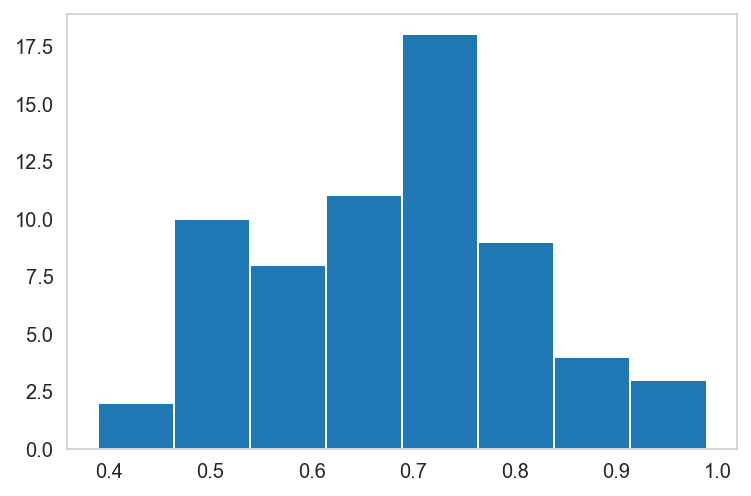

In [13]:
fig, ax = plt.subplots(1,1)
ax.hist(dx.value,bins=8)
ax.grid(False)
fig.savefig('../../output/proximity_predictions/images/auc_distribution.eps', dpi = 300)